# Minimum Volume Truss Optimization

The minimum volume problem aims to find the optimal layout (topology) and
cross-sectional areas of truss members that minimize the total structural
volume (and hence, typically the material usage and cost).

The linear programming formulation (LP) of the problem is to minimize the sum
of the cross-sectional areas of the truss members within the ground structure
multiplied by their lengths, thereby finding the minimum total volume of the
structure. The model considers static equilibrium between the horizontal and
vertical bar forces and the applied loads. The bar forces are constrained by
stress limits for tension and compression. The topological decisions arise from
the separation of variables into basic and non-basic variables, i.e., bars
associated with non-basic variables (zero-force members) can be eliminated from
the ground structure [1].

The LP is taken from Oberndorfer et al. [1] and implemented using the 
Pyomo modeling language [2].

Author: Marvin Meck (https://github.com/marvin-meck/)

## Linear Programming Formulation

$$
\newcommand{\NumBars}{m}
\newcommand{\NumNodes}{n}
\newcommand{\BarLength}{l}
\newcommand{\CrossSection}{A}
\newcommand{\Diameter}{D}
\newcommand{\BarForce}{S}
\newcommand{\ExtForce}{F}
% \newcommand{\EquilibriumMatrix}{\vb{B}}}
\newcommand{\EquilibriumMatrixElement}{b}
\newcommand{\StressLimitTension}{\sigma_T}
\newcommand{\StressLimitCompression}{\sigma_C}
\newcommand{\YoungsModulus}{E}
\newcommand{\InertiaMomentOfArea}{I}
%
\begin{aligned}
    \min_{\BarForce_i,\CrossSection_i} 
                &\quad \sum_{j=1}^{\NumBars} { \BarLength_j \CrossSection_j } \\
    \text{s.t.} &\quad \sum_{j=1}^{\NumBars} \EquilibriumMatrixElement_{kj} \BarForce_j + \ExtForce_k = 0&&\qquad \forall k = 1,\ldots,2\NumNodes \\
                &\quad \BarForce_k \geq - \StressLimitCompression\,\CrossSection_k &&\qquad \forall k = 1,\ldots,\NumBars \\
                &\quad \BarForce_k \leq  \StressLimitTension\,\CrossSection_k &&\qquad \forall k = 1,\ldots,\NumBars \\
                    &\quad \CrossSection_i \geq 0 &&\qquad \forall i = 1,\ldots,\NumBars 
\end{aligned}
$$

## Example: Cantilever

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import json

import pyomo.environ as pyo
from minimum_volume_problem import pyomo_create_model

glpk = pyo.SolverFactory("glpk")

### Create Ground Structure

In [2]:
!python create_ground_structure.py

In [3]:
import pandas as pd

edf = pd.read_csv("./data/bars.csv", index_col="edge ID") 
vdf = pd.read_csv("./data/vertices.csv", index_col="vertex ID")

In [4]:
vdf

,coords_x,coords_y,label,node_force_vertical,node_force_horizontal
vertex ID,,,,,
0,0,0,a,-100,-400
1,1,0,b,0,0
2,2,0,c,0,0
3,3,0,d,0,0
4,4,0,e,0,0
5,0,1,f,0,400
6,1,1,g,0,0
7,2,1,h,0,0
8,3,1,i,0,0


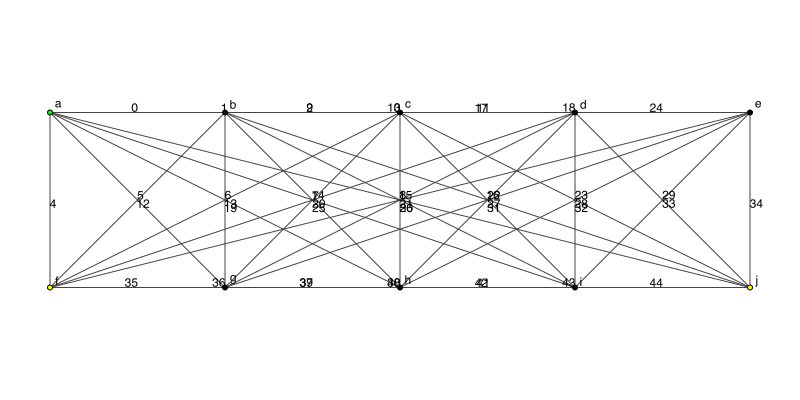

In [5]:
from minimum_volume_problem import _plot_topology
_plot_topology(bbox=(800,400))

### Solve

In [6]:
!pyomo solve --solver glpk minimum_volume_problem.py

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.25] Creating model
[    0.26] Applying solver
[    0.28] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: feasible
      Function Value: 8628.571428571424
    Solver results file: results.yml
[    0.28] Applying Pyomo postprocessing actions
[    0.28] Pyomo Finished
ERROR: Unexpected exception while running model:
        pyomo_postprocess() got an unexpected keyword argument 'results'. Did
        you mean 'reults'?


### Solution

In [7]:
from pyomo.opt import SolverResults
from minimum_volume_problem import pyomo_create_model

model = pyomo_create_model()
instance = model.create_instance("data/data.json")

In [8]:
results = SolverResults()
results.read(filename="results.yml")

# fix some stuff -> TODO: PR Pyomo Repo
results.solution(0)._cuid = False
results.solution.Constraint = {}

instance.solutions.load_from(results)
# , default_variable_value=0) # doesn't work because smap_id = None

for var in instance.component_data_objects(pyo.Var):
    if var.value is None:
        var.value = 0

In [9]:
# instance.bar_force.extract_values()

In [10]:
# instance.bar_cross_section.extract_values()

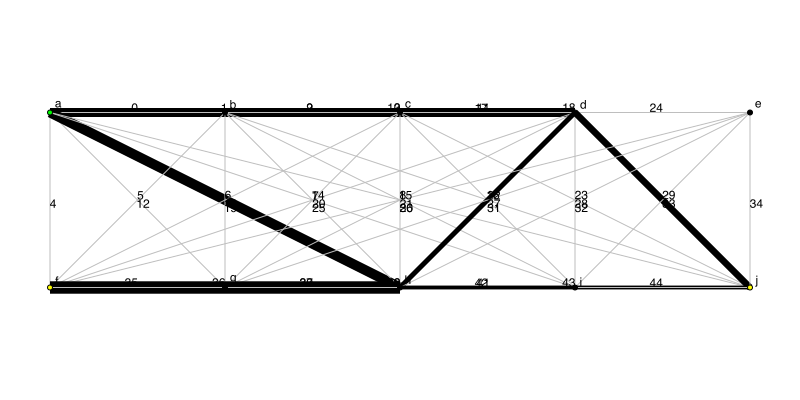

In [11]:
visual_style = dict(
    bbox=(800,400),
    edge_color=[ "black" if abs(pyo.value(instance.bar_force[k])) >= 1e-6 else "gray" for k in instance.SetBars],
    edge_width=[ 10*abs(pyo.value(instance.bar_cross_section[k]))+1 for k in instance.SetBars]
)

_plot_topology(**visual_style)

## References:

[1]  J. M. Oberndorfer, W. Achtziger, and Hörnlein, H. R. E. M., “Two
     approaches for truss topology optimization: a comparison for practical
     use,” Structural Optimization, vol. 11, no. 3–4, pp. 137–144, Jan. 1996,
     doi: 10.1007/BF01197027.

[2]  W. E. Hart, J.-P. Watson, C. D. Laird, B. L. Nicholson, and J. D. Siirola,
     Pyomo: Optimization Modeling in Python, Second edition / William E Hart
     [and six others]., vol. 67. in Springer Optimization and Its Applications,
     vol. 67. Cham: Springer, 2017.